# Final Paper: Brayton Cycle Simulation

## Ideal Brayton Cycle

2.205398042820035


Text(0.5, 1.0, 'T-S Diagram for Brayton Cycle (pr = 11)')

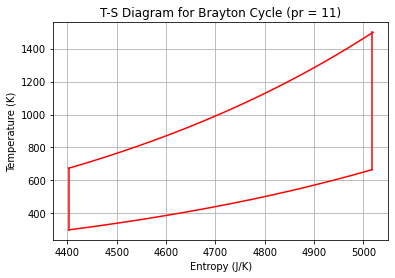

In [49]:
# Imports
import matplotlib.pyplot as plt
import ipywidgets as wig
import math

# Mechanical Constants
TURBINE_LEN_M = 3.9
TURBINE_RAD_M = 1.2
INLET_FRAC = 1 / 8

# Thermodynamic Constants
PRESSURE_RATIO = 17
INLET_PRESSURE = 100
INLET_TEMP = 300
DEG_FREE = 5
MAX_TEMP = 1500 # 2250

def isentropicTf(ti, pr):
    gamma = (DEG_FREE + 2) / DEG_FREE
    return int(ti * (pr) ** ((gamma - 1) / gamma))

# Derived Constants
POST_COMPRESS_TEMP = isentropicTf(INLET_TEMP, PRESSURE_RATIO)
POST_EXPAN_TEMP = isentropicTf(MAX_TEMP, 1 / PRESSURE_RATIO)
INLET_VOLUME = INLET_FRAC * TURBINE_RAD_M ** 2 * math.pi * TURBINE_LEN_M
print(INLET_VOLUME)
NKB = INLET_PRESSURE * INLET_VOLUME
CP = (DEG_FREE + 2) / 2 * NKB

# Initilizing Temperature Lists
t_one_two = list(i for i in range(INLET_TEMP, POST_COMPRESS_TEMP))
t_two_three = list(i for i in range(POST_COMPRESS_TEMP, MAX_TEMP))
t_three_four = list(i for i in range(POST_EXPAN_TEMP,MAX_TEMP)) # Reversed
t_four_one = list(i for i in range(INLET_TEMP, POST_EXPAN_TEMP)) # Reversed

# Initializing Entropy Lists
s_one_two = list()
s_two_three = list()
s_three_four = list()
s_four_one = list()

# Populating Entropy Lists
for i in range(len(t_four_one)):
    s_four_one.append(math.log(t_four_one[i]) * CP)

ENTROPY_CORR = s_four_one[0] - (math.log(t_two_three[0]) * CP)      

for i in range(len(t_two_three)):
    s_two_three.append(math.log(t_two_three[i]) * CP + ENTROPY_CORR)

for i in range(len(t_one_two)):
    s_one_two.append(s_four_one[0])

for i in range(len(t_three_four)):
    s_three_four.append(s_four_one[-1])

# Plotting
plt.plot(s_one_two, t_one_two, color = "red")
plt.plot(s_two_three, t_two_three, color = "red")
plt.plot(s_three_four, t_three_four, color = "red")
plt.plot(s_four_one, t_four_one, color = "red")

# Configuring Plot
plt.grid(b = 1)
plt.xlabel("Entropy (J/K)")
plt.ylabel("Temperature (K)")
plt.title("T-S Diagram for Brayton Cycle (pr = 11)")


## Numerical Efficiency Calculation

In [50]:
qIn = 0
qOut = 0

for i in range(len(t_two_three) - 1):
    qIn = qIn + t_two_three[i] * (s_two_three[i + 1] - s_two_three[i])
    
for i in range(len(t_four_one) - 1):
    qOut = qOut + t_four_one[i] * (s_four_one[i + 1] - s_four_one[i])
    
print(1 - qOut/qIn)
print( int(qIn - qOut))
    

0.5566320411224978
354296


## Brayton Cycle Appproaching Eriksson Cycle

In [67]:
def plotCycle(compressors):
    
    # Constant for number of intercooling / reheating steps
    COOLING_COMPRESS = compressors
    HEATING_COMPRESS = COOLING_COMPRESS

    INLET_PRESSURE = 100
    INLET_TEMP = 300
    INITIAL_ENTROPY = math.log(300) * CP

    intercooling_steps = list()
    reheating_steps = list()

    for i in range(COOLING_COMPRESS * 2 + 1):
        intercooling_steps.append((list(), list()))

    for i in range(HEATING_COMPRESS * 2 + 1):
        reheating_steps.append((list(), list()))

    # Reccursive Function for Determining One Intermediate Pressure
    def dispatchPres(steps, ph, pl, value, count):
        if count == 0:
            value = ph

        if int(ph / value) > int(value / pl):
            return dispatchPres(steps, ph, pl, value + 1, count + 1)
        elif int(ph / value) < int(value / pl):
            return dispatchPres(steps, ph, pl, value - 1, count + 1)
        else:
            return value

    # Reccursive Function to Determine Intermediate Pressures
    def presSteps(vals):    
        j = True
        for i in range(len(vals) - 2):
            if not round(vals[i + 1] / vals[i], 1) == round(vals[i + 2] / vals[i + 1], 1):
                j = False
        if j:
            return vals
        else:
            for i in range(len(vals) - 2):
                if round(vals[i + 1] / vals[i], 1) > round(vals[i + 2] / vals[i + 1], 1):
                    vals[i + 1] = vals[i + 1] - 1
                elif round(vals[i + 1] / vals[i], 1) > round(vals[i + 2] / vals[i + 1], 1):
                    vals[i + 1] = vals[i + 1] + 1
            return presSteps(vals)

    # Helper Function to Initialize List of Intermediate Pressures
    def _initVals(steps, ph, pl):
        vals = list()
        mult = int((ph - pl) / steps)
        vals.append(pl)
        for i in range(1, steps):
            vals.append(pl + i * mult)
        vals.append(ph)
        return vals

    intermediate_pres = presSteps(_initVals(COOLING_COMPRESS + 1, INLET_PRESSURE * PRESSURE_RATIO, INLET_PRESSURE))

    if len(intermediate_pres) > 2:
        # Plot Brayton Cycle with intercooling and reheating
        GAMMA = (DEG_FREE + 2) / (DEG_FREE)

        TEMP_RATIO = round((intermediate_pres[1] / intermediate_pres[0]) ** ((GAMMA - 1)/GAMMA), 2)

        ENTROPY_CORR = INITIAL_ENTROPY

        for i in range(len(intercooling_steps)):
            if i % 2 == 0:

                if i != 0:

                    ENTROPY_CORR = intercooling_steps[i-1][-1][0]

                for j in range(INLET_TEMP,round(INLET_TEMP * TEMP_RATIO)): 

                    intercooling_steps[i][0].append(j)
                    intercooling_steps[i][-1].append(ENTROPY_CORR)
            else:
                for j in range(INLET_TEMP,round(INLET_TEMP * TEMP_RATIO)):


                    if j == INLET_TEMP:

                        ENTROPY_CORR = intercooling_steps[i-1][-1][0] - math.log(INLET_TEMP * TEMP_RATIO) * CP

                    intercooling_steps[i][0].append(j)
                    intercooling_steps[i][-1].append(math.log(j) * CP + ENTROPY_CORR)

            plt.plot(intercooling_steps[i][-1], intercooling_steps[i][0], color = "red")

        t_two_three = list(i for i in range(int(intercooling_steps[-1][0][-1]), MAX_TEMP))
        s_two_three = list(math.log(t_two_three[i]) * CP + intercooling_steps[-1][-1][-1] - math.log(t_two_three[0]) * CP for i in range(len(t_two_three)))
        plt.plot(s_two_three, t_two_three, color = "red")

        ENTROPY_CORR = s_two_three[-1]

        for i in range(len(reheating_steps)):

            if i % 2 == 0:

                if i != 0:

                    ENTROPY_CORR = reheating_steps[i-1][-1][-1]

                for j in range(round(MAX_TEMP / TEMP_RATIO), MAX_TEMP): 

                    reheating_steps[i][0].append(j)
                    reheating_steps[i][-1].append(ENTROPY_CORR)
            else:
                for j in range(round(MAX_TEMP / TEMP_RATIO), MAX_TEMP):

                    if j == round(MAX_TEMP / TEMP_RATIO):

                        ENTROPY_CORR = reheating_steps[i-1][-1][-1] - math.log(MAX_TEMP/TEMP_RATIO) * CP

                    reheating_steps[i][0].append(j)
                    reheating_steps[i][-1].append(math.log(j) * CP + ENTROPY_CORR)

            plt.plot(reheating_steps[i][-1], reheating_steps[i][0], color = "red")

        t_four_one = list(i for i in range(INLET_TEMP, reheating_steps[-1][0][0]))
        s_four_one = list(math.log(t_four_one[i]) * CP for i in range(len(t_four_one)))
        plt.plot(s_four_one, t_four_one, color = "red")
    else:
        # Plot Brayton Cycle without Intercooling and Reheating
        # Initilizing Temperature Lists
        t_one_two = list(i for i in range(INLET_TEMP, POST_COMPRESS_TEMP))
        t_two_three = list(i for i in range(POST_COMPRESS_TEMP, MAX_TEMP))
        t_three_four = list(i for i in range(POST_EXPAN_TEMP,MAX_TEMP)) # Reversed
        t_four_one = list(i for i in range(INLET_TEMP, POST_EXPAN_TEMP)) # Reversed

        # Initializing Entropy Lists
        s_one_two = list()
        s_two_three = list()
        s_three_four = list()
        s_four_one = list()

        # Populating Entropy Lists
        for i in range(len(t_four_one)):
            s_four_one.append(math.log(t_four_one[i]) * CP)

        ENTROPY_CORR = s_four_one[0] - (math.log(t_two_three[0]) * CP)      

        for i in range(len(t_two_three)):
            s_two_three.append(math.log(t_two_three[i]) * CP + ENTROPY_CORR)

        for i in range(len(t_one_two)):
            s_one_two.append(s_four_one[0])

        for i in range(len(t_three_four)):
            s_three_four.append(s_four_one[-1])

        # Plotting
        plt.plot(s_one_two, t_one_two, color = "red")
        plt.plot(s_two_three, t_two_three, color = "red")
        plt.plot(s_three_four, t_three_four, color = "red")
        plt.plot(s_four_one, t_four_one, color = "red")

    plt.grid(b = 1)
    plt.xlabel("Entropy (J/K)")
    plt.ylabel("Temperature (K)")
    plt.title("10 Extra Compressors and Turbines")


In [68]:
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual

interact(plotCycle, compressors = (0,50))

interactive(children=(IntSlider(value=25, description='compressors', max=50), Output()), _dom_classes=('widget…

<function __main__.plotCycle(compressors)>

## Varying Pressure Ratio

Text(0.5, 1.0, 'Varying Pressure Ratio from 3-100')

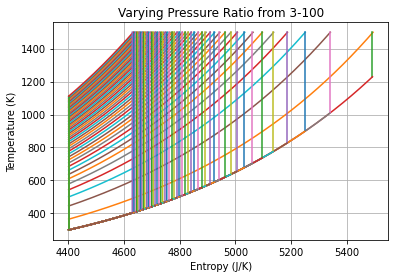

In [42]:

PRESSURE_RATIOS = list(i for i in range(2,100,2))

# PRESSURE_RATIOS = list()

# PRESSURE_RATIOS.append((3, "red"))
# PRESSURE_RATIOS.append((6, "blue"))
# PRESSURE_RATIOS.append((8.3, "gray"))
# PRESSURE_RATIOS.append((15, "green"))
# PRESSURE_RATIOS.append((30, "purple"))
# PRESSURE_RATIOS.append((50, "black"))
# PRESSURE_RATIOS.append((100, "yellow"))

work = list()

for p in PRESSURE_RATIOS:
    
    # Derived Constants
#     POST_COMPRESS_TEMP = isentropicTf(INLET_TEMP, p[0])
#     POST_EXPAN_TEMP = isentropicTf(MAX_TEMP, 1 / p[0])

    POST_COMPRESS_TEMP = isentropicTf(INLET_TEMP, p)
    POST_EXPAN_TEMP = isentropicTf(MAX_TEMP, 1 / p)
    INLET_VOLUME = INLET_FRAC * TURBINE_RAD_M ** 2 * math.pi * TURBINE_LEN_M
    NKB = INLET_PRESSURE * INLET_VOLUME
    CP = (DEG_FREE + 2) / 2 * NKB

    # Initilizing Temperature Lists
    t_one_two = list(i for i in range(INLET_TEMP, POST_COMPRESS_TEMP))
    t_two_three = list(i for i in range(POST_COMPRESS_TEMP, MAX_TEMP))
    t_three_four = list(i for i in range(POST_EXPAN_TEMP,MAX_TEMP)) # Reversed
    t_four_one = list(i for i in range(INLET_TEMP, POST_EXPAN_TEMP)) # Reversed

    # Initializing Entropy Lists
    s_one_two = list()
    s_two_three = list()
    s_three_four = list()
    s_four_one = list()
    
    # Populating Entropy Lists
    for i in range(len(t_four_one)):
        s_four_one.append(math.log(t_four_one[i]) * CP)

    ENTROPY_CORR = s_four_one[0] - (math.log(t_two_three[0]) * CP)      
        
    for i in range(len(t_two_three)):
        s_two_three.append(math.log(t_two_three[i]) * CP + ENTROPY_CORR)

    for i in range(len(t_one_two)):
        s_one_two.append(s_four_one[0])

    for i in range(len(t_three_four)):
        s_three_four.append(s_four_one[-1])

    # Plotting
    plt.plot(s_one_two, t_one_two )#, color = p[-1])
    plt.plot(s_two_three, t_two_three )#, color = p[-1])
    plt.plot(s_three_four, t_three_four )#, color = p[-1])
    plt.plot(s_four_one, t_four_one) #, color = p[-1])

#     plt.plot(s_one_two, t_one_two)
#     plt.plot(s_two_three, t_two_three)
#     plt.plot(s_three_four, t_three_four)
#     plt.plot(s_four_one, t_four_one)
    
    qIn = 0
    qOut = 0

    for i in range(len(t_two_three) - 1):
        qIn = qIn + t_two_three[i] * (s_two_three[i + 1] - s_two_three[i])

    for i in range(len(t_four_one) - 1):
        qOut = qOut + t_four_one[i] * (s_four_one[i + 1] - s_four_one[i])
        
    work.append(qIn - qOut)
    
plt.grid(b = 1)
plt.xlabel("Entropy (J/K)")
plt.ylabel("Temperature (K)")
plt.title("Varying Pressure Ratio from 3-100")

Text(0.5, 1.0, 'Work VS Pressure Ratio for pr from 3-100')

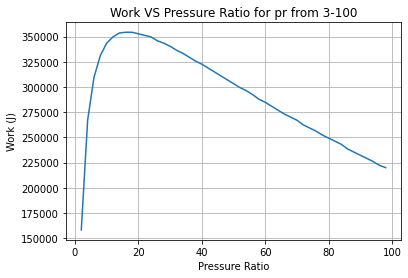

In [48]:
pr = list(PRESSURE_RATIOS[i] for i in range(len(PRESSURE_RATIOS)))

plt.plot(pr, work)

plt.grid(b = 1)
plt.xlabel("Pressure Ratio")
plt.ylabel("Work (J)")
plt.title("Work VS Pressure Ratio for pr from 3-100")